# 초기 세팅

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [ ]:
!pip install torchsummary
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install torchinfo
from torchinfo import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


- 현재 GPU 설정

In [ ]:
# colab의 runtime-type을 GPU로 설정해서, True가 나오도록 한다.

torch.cuda.is_available()

True

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

# FashionMNIST 분류 모델 만들기
* 흑/백(1) 이미지 데이터 분류
* 28x28 pixel

## 데이터 로드

In [ ]:
# 데이터 전처리

MNIST_transform = transforms.Compose([transforms.ToTensor(), # tensor로 펴준다.
                                      transforms.Normalize((0.5,),(0.5,))]) # 정규화를 해준다.

In [ ]:
trainset = datasets.FashionMNIST(root='/content',
                                 train=True, download=True,
                                 transform=MNIST_transform)

testset = datasets.FashionMNIST(root='/content',
                                 train=False, download=True,
                                 transform=MNIST_transform)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



input-data size 확인

In [ ]:
# batch-size=128
train_loader128 =  DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
test_loader128 =  DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# batch-size=64
train_loader64 =  DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader64 =  DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

In [ ]:
# 128 : batch-size
# 1 : 흑백
# 28x28 : pixel-size

images128, labels128 = next(iter(train_loader128))
images128.shape, labels128.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [ ]:
# 64 : batch-size
# 1 : 흑백
# 28x28 : pixel-size

images64, labels64 = next(iter(train_loader64))
images64.shape, labels64.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [ ]:
# 숫자 label에 해당되는 값

labels_map = {
    0: 'T-Shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot'
}

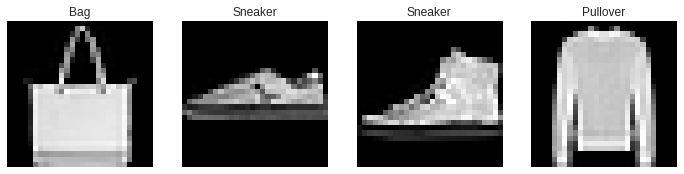

In [ ]:
# 데이터 확인

figure = plt.figure(figsize=(12,12))
cols, rows = 4, 1

for i in range(1, cols * rows + 1):
    image = images128[i].squeeze()
    label_idx = labels128[i].item() # y_label
    label = labels_map[label_idx] # 위에서 해당되는 label

    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(image, cmap='gray')

plt.show()

## 모델 1 생성
* 10개의 convolution-layer(Conv2d)와 2개의 fully-connected(fc)로 이루어진 모델
* Total params: 28,784

input-data size
* train_loader128(batch-size;128) : 128, 1, 28, 28
* train_loader64(batch-size;64) : 64, 1, 28, 28


구현해야하는 모델 정보<br>
* convolution-layer 1
* maxpooling-layer
* convolution-layer 2
* convolution-layer 3
* convolution-layer 4
* convolution-layer 5
* convolution-layer 6
* convolution-layer 7
* convolution-layer 8
* convolution-layer 9
* maxpooling-layer
* convolution-layer 10
* flatten
* fc1
* fc2

추가 정보
* 활성화함수 : relu
(단, maxpooling과 마지막 fc2에는 보통적으로 활성화함수를 사용하지 않는다.)
* flatten의 경우, weights가 들어가지 않는다. 즉, layer라고는 볼 수 없다.

모델의 layer를 통과함에 따라 데이터의 크기 변화는 다음과 같다.
1. batch-size128 -> torch.Size([128, 1, 28, 28]) 으로 시작
2. batch-size;64 -> torch.Size([64, 1, 28, 28]) 으로 시작
> * torch.Size([128 or 64, 5, 30, 30])
> * torch.Size([128 or 64, 5, 15, 15])
> * torch.Size([128 or 64, 7, 15, 15])
> * torch.Size([128 or 64, 16, 16, 16])
> * torch.Size([128 or 64, 19, 15, 15])
> * torch.Size([128 or 64, 29, 13, 13])
> * torch.Size([128 or 64, 29, 14, 14])
> * torch.Size([128 or 64, 6, 12, 12])
> * torch.Size([128 or 64, 2, 12, 12])
> * torch.Size([128 or 64, 10, 7, 7])
> * torch.Size([128 or 64, 20, 7, 7])
> * torch.Size([128 or 64, 20, 3, 3])
> * torch.Size([128 or 64, 180])
> * torch.Size([128 or 64, 86])
> * torch.Size([128 or 64, 10]) 

In [ ]:
class CNN_Model1(nn.Module):
    def __init__(self):
        super(CNN_Model1, self).__init__()



        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, stride=1, padding=2)
        # in-channels = 1 <- 흑/백
        # out-channels = 5
        # kernel_size / filter-size = 2x2 -> f=3
        # stride = 1(default) -> s=1
        # padding = 2(default) -> p=2
        # input-data pixel size = 28x28 -> n=28
        # (n-f+2p)/s + 1 = new n
        # (28-3+2x2)/1 + 1 = 30
    
        # maxpool : n=30 -> 15

        self.conv2 = nn.Conv2d(5, 7, 3, padding=1)
        # in-channels = 5 <- 이전것의 out-channels
        # out-channels = 7
        # filter-size = 3x3
        # stride = 1(default)
        # padding = 1
        # (n-f+2p)/s + 1 = new n    
        # (15-3+2x1)/1 + 1 = 15

        self.conv3 = nn.Conv2d(7,16,2,padding=1)
        self.conv4 = nn.Conv2d(16,19,2,padding=0)
        self.conv5 = nn.Conv2d(19,29,3,padding=0)
        self.conv6 = nn.Conv2d(29,29,2,padding=1)
        self.conv7 = nn.Conv2d(29,6,3,padding=0)
        self.conv8 = nn.Conv2d(6,2,1,padding=0)
        self.conv9 = nn.Conv2d(2,10,2,2,1)
        self.conv10 = nn.Conv2d(10,20,1,padding=0)

        self.fc1 = nn.Linear(180, 86)
        self.fc2 = nn.Linear(86, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.conv10(x))

        x = x.view(-1, self.num_flat_features(x)) # num_flat_features : 아래에서 정의

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def num_flat_features(self, x): # 처음 dim-size을 제외하고, 모두 곱한 값을 반환해준다.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [ ]:
# 모델객체 생성
DeepConv_net128 = CNN_Model1().to(device)
DeepConv_net64 = CNN_Model1().to(device)

print(DeepConv_net128)

CNN_Model1(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(5, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(7, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 19, kernel_size=(2, 2), stride=(1, 1))
  (conv5): Conv2d(19, 29, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(29, 29, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(29, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv8): Conv2d(6, 2, kernel_size=(1, 1), stride=(1, 1))
  (conv9): Conv2d(2, 10, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
  (conv10): Conv2d(10, 20, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=180, out_features=86, bias=True)
  (fc2): Linear(in_features=86, out_features=10, bias=True)
)


In [ ]:
input = images128.to(device)
input.size()

torch.Size([128, 1, 28, 28])

In [ ]:
output = DeepConv_net128.forward(input)
output.size()

torch.Size([128, 10])

In [ ]:
summary(DeepConv_net128, input_size=(128, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_Model1                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 5, 30, 30]          50
├─Conv2d: 1-2                            [128, 7, 15, 15]          322
├─Conv2d: 1-3                            [128, 16, 16, 16]         464
├─Conv2d: 1-4                            [128, 19, 15, 15]         1,235
├─Conv2d: 1-5                            [128, 29, 13, 13]         4,988
├─Conv2d: 1-6                            [128, 29, 14, 14]         3,393
├─Conv2d: 1-7                            [128, 6, 12, 12]          1,572
├─Conv2d: 1-8                            [128, 2, 12, 12]          14
├─Conv2d: 1-9                            [128, 10, 7, 7]           90
├─Conv2d: 1-10                           [128, 20, 3, 3]           220
├─Linear: 1-11                           [128, 86]                 15,566
├─Linear: 1-12                           [128, 10]                

In [ ]:
input = images64.to(device)
input.size()

torch.Size([64, 1, 28, 28])

In [ ]:
output = DeepConv_net64.forward(input)
output.size()

torch.Size([64, 10])

In [ ]:
summary(DeepConv_net64, input_size=(128, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_Model1                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 5, 30, 30]          50
├─Conv2d: 1-2                            [128, 7, 15, 15]          322
├─Conv2d: 1-3                            [128, 16, 16, 16]         464
├─Conv2d: 1-4                            [128, 19, 15, 15]         1,235
├─Conv2d: 1-5                            [128, 29, 13, 13]         4,988
├─Conv2d: 1-6                            [128, 29, 14, 14]         3,393
├─Conv2d: 1-7                            [128, 6, 12, 12]          1,572
├─Conv2d: 1-8                            [128, 2, 12, 12]          14
├─Conv2d: 1-9                            [128, 10, 7, 7]           90
├─Conv2d: 1-10                           [128, 20, 3, 3]           220
├─Linear: 1-11                           [128, 86]                 15,566
├─Linear: 1-12                           [128, 10]                

## 모델 2 생성
* 2개의 convolution-layer(Conv2d)와 5개의 fully-connected(fc)로 이루어진 모델
* Total params: 9,516,488

input-data size
* train_loader128(batch-size;128) : 128, 1, 28, 28
* train_loader64(batch-size;64) : 64, 1, 28, 28


구현해야하는 모델 정보<br>
* convolution-layer 1
* maxpooling-layer
* convolution-layer 2
* flatten
* fc1
* fc2
* fc3
* fc4
* fc5

추가 정보
* 활성화함수 : relu
(단, maxpooling과 마지막 fc5에는 보통적으로 활성화함수를 사용하지 않는다.)
* flatten의 경우, weights가 들어가지 않는다. 즉, layer라고는 볼 수 없다.

모델의 layer를 통과함에 따라 데이터의 크기 변화는 다음과 같다.

1. batch-size128 -> torch.Size([128, 1, 28, 28]) 으로 시작
2. batch-size;64 -> torch.Size([64, 1, 28, 28]) 으로 시작
> * torch.Size([128 or 64, 5, 30, 30])
> * torch.Size([128 or 64, 5, 15, 15])
> * torch.Size([128 or 64, 7, 15, 15])
> * torch.Size([128 or 64, 1575])
> * torch.Size([128 or 64, 3000])
> * torch.Size([128 or 64, 1500])
> * torch.Size([128 or 64, 180])
> * torch.Size([128 or 64, 86])
> * torch.Size([128 or 64, 10])

In [ ]:
class CNN_Model2(nn.Module):
    def __init__(self):
        super(CNN_Model2, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, stride=1, padding=2)
        self.conv2 = nn.Conv2d(5, 7, 3, padding=1)
        self.fc1 = nn.Linear(1575, 3000)
        self.fc2 = nn.Linear(3000, 1500)
        self.fc3 = nn.Linear(1500, 180)
        self.fc4 = nn.Linear(180, 86)
        self.fc5 = nn.Linear(86, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2, 2))
        x = F.relu(self.conv2(x))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x
    
    def num_flat_features(self, x): # 처음 dim-size을 제외하고, 모두 곱한 값을 반환해준다.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [ ]:
# 모델객체 생성
DeepFC_net128 = CNN_Model2().to(device)
DeepFC_net64 = CNN_Model2().to(device)

print(DeepFC_net128)

CNN_Model2(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(5, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1575, out_features=3000, bias=True)
  (fc2): Linear(in_features=3000, out_features=1500, bias=True)
  (fc3): Linear(in_features=1500, out_features=180, bias=True)
  (fc4): Linear(in_features=180, out_features=86, bias=True)
  (fc5): Linear(in_features=86, out_features=10, bias=True)
)


In [ ]:
input = images128.to(device)
input.size()

torch.Size([128, 1, 28, 28])

In [ ]:
output = DeepFC_net128.forward(input)
output.size()

torch.Size([128, 10])

In [ ]:
summary(DeepFC_net128, input_size=(128, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_Model2                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 5, 30, 30]          50
├─Conv2d: 1-2                            [128, 7, 15, 15]          322
├─Linear: 1-3                            [128, 3000]               4,728,000
├─Linear: 1-4                            [128, 1500]               4,501,500
├─Linear: 1-5                            [128, 180]                270,180
├─Linear: 1-6                            [128, 86]                 15,566
├─Linear: 1-7                            [128, 10]                 870
Total params: 9,516,488
Trainable params: 9,516,488
Non-trainable params: 0
Total mult-adds (G): 1.23
Input size (MB): 0.40
Forward/backward pass size (MB): 11.11
Params size (MB): 38.07
Estimated Total Size (MB): 49.58

In [ ]:
input = images64.to(device)
input.size()

torch.Size([64, 1, 28, 28])

In [ ]:
output = DeepFC_net64.forward(input)
output.size()

torch.Size([64, 10])

In [ ]:
summary(DeepFC_net64, input_size=(64, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_Model2                               [64, 10]                  --
├─Conv2d: 1-1                            [64, 5, 30, 30]           50
├─Conv2d: 1-2                            [64, 7, 15, 15]           322
├─Linear: 1-3                            [64, 3000]                4,728,000
├─Linear: 1-4                            [64, 1500]                4,501,500
├─Linear: 1-5                            [64, 180]                 270,180
├─Linear: 1-6                            [64, 86]                  15,566
├─Linear: 1-7                            [64, 10]                  870
Total params: 9,516,488
Trainable params: 9,516,488
Non-trainable params: 0
Total mult-adds (M): 616.55
Input size (MB): 0.20
Forward/backward pass size (MB): 5.56
Params size (MB): 38.07
Estimated Total Size (MB): 43.82

## 손실함수와 옵티마이저

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizerDC_128 = optim.SGD(DeepConv_net128.parameters(), lr=0.001, momentum=0.9)
optimizerDC_64 = optim.SGD(DeepConv_net64.parameters(), lr=0.001, momentum=0.9)
optimizerFC_128 = optim.SGD(DeepFC_net128.parameters(), lr=0.001, momentum=0.9)
optimizerFC_64 = optim.SGD(DeepFC_net64.parameters(), lr=0.001, momentum=0.9)

## 모델 학습

### 1. DeepConv_net128
* 10개의 Convolution-layer & 2개의 fc-layer
* 128 batch-size

In [ ]:
for epoch in range(10):

    running_loss = 0.0

    for i, data in enumerate(train_loader128, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizerDC_128.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = DeepConv_net128(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizerDC_128.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=128
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11527664482593536
Epoch: 1, Iter: 200, Loss: 0.11522419607639313
Epoch: 1, Iter: 300, Loss: 0.11522263312339782
Epoch: 1, Iter: 400, Loss: 0.11521088480949401
Epoch: 2, Iter: 100, Loss: 0.11517347049713135
Epoch: 2, Iter: 200, Loss: 0.11512159311771393
Epoch: 2, Iter: 300, Loss: 0.11515030777454376
Epoch: 2, Iter: 400, Loss: 0.11516574919223785
Epoch: 3, Iter: 100, Loss: 0.11514479506015778
Epoch: 3, Iter: 200, Loss: 0.11514024698734283
Epoch: 3, Iter: 300, Loss: 0.11512989592552185
Epoch: 3, Iter: 400, Loss: 0.11513272869586945
Epoch: 4, Iter: 100, Loss: 0.11513517045974732
Epoch: 4, Iter: 200, Loss: 0.11512883841991424
Epoch: 4, Iter: 300, Loss: 0.11513325035572052
Epoch: 4, Iter: 400, Loss: 0.11513673341274261
Epoch: 5, Iter: 100, Loss: 0.11513333332538604
Epoch: 5, Iter: 200, Loss: 0.11513241565227508
Epoch: 5, Iter: 300, Loss: 0.11513211369514466
Epoch: 5, Iter: 400, Loss: 0.11513308525085449
Epoch: 6, Iter: 100, Loss: 0.11513172805309296
Epoch: 6, Ite

In [ ]:
for epoch in range(5):

    running_loss = 0.0

    for i, data in enumerate(train_loader128, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizerDC_128.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = DeepConv_net128(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizerDC_128.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=128
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11513105475902558
Epoch: 1, Iter: 200, Loss: 0.11512936890125275
Epoch: 1, Iter: 300, Loss: 0.11513281655311584
Epoch: 1, Iter: 400, Loss: 0.11513279390335084
Epoch: 2, Iter: 100, Loss: 0.11512879920005799
Epoch: 2, Iter: 200, Loss: 0.11513299942016601
Epoch: 2, Iter: 300, Loss: 0.1151317138671875
Epoch: 2, Iter: 400, Loss: 0.11513170886039734
Epoch: 3, Iter: 100, Loss: 0.11513097989559173
Epoch: 3, Iter: 200, Loss: 0.11513098526000977
Epoch: 3, Iter: 300, Loss: 0.11513347935676575
Epoch: 3, Iter: 400, Loss: 0.11513099122047424
Epoch: 4, Iter: 100, Loss: 0.11512867891788482
Epoch: 4, Iter: 200, Loss: 0.11513174986839295
Epoch: 4, Iter: 300, Loss: 0.11513203811645507
Epoch: 4, Iter: 400, Loss: 0.11513381159305572
Epoch: 5, Iter: 100, Loss: 0.11512844967842102
Epoch: 5, Iter: 200, Loss: 0.1151325204372406
Epoch: 5, Iter: 300, Loss: 0.11513305163383483
Epoch: 5, Iter: 400, Loss: 0.11513123059272766


### 2. DeepConv_net64
* 10개의 Convolution-layer & 2개의 fc-layer
* 64 batch-size

In [ ]:
for epoch in range(10):

    running_loss = 0.0

    for i, data in enumerate(train_loader64, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizerDC_64.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = DeepConv_net64(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizerDC_64.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=64
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11518771028518676
Epoch: 1, Iter: 200, Loss: 0.11514706444740296
Epoch: 1, Iter: 300, Loss: 0.11513859760761261
Epoch: 1, Iter: 400, Loss: 0.11515025019645692
Epoch: 1, Iter: 500, Loss: 0.11513884723186493
Epoch: 1, Iter: 600, Loss: 0.11514225149154664
Epoch: 1, Iter: 700, Loss: 0.11514530754089355
Epoch: 1, Iter: 800, Loss: 0.11512990605831146
Epoch: 1, Iter: 900, Loss: 0.11513261187076569
Epoch: 2, Iter: 100, Loss: 0.11513822674751281
Epoch: 2, Iter: 200, Loss: 0.1151351238489151
Epoch: 2, Iter: 300, Loss: 0.11513129687309265
Epoch: 2, Iter: 400, Loss: 0.11513244938850403
Epoch: 2, Iter: 500, Loss: 0.11513331210613251
Epoch: 2, Iter: 600, Loss: 0.11513306891918182
Epoch: 2, Iter: 700, Loss: 0.11513497936725617
Epoch: 2, Iter: 800, Loss: 0.11513878393173217
Epoch: 2, Iter: 900, Loss: 0.1151366981267929
Epoch: 3, Iter: 100, Loss: 0.11513370466232299
Epoch: 3, Iter: 200, Loss: 0.11512832200527191
Epoch: 3, Iter: 300, Loss: 0.11514208114147187
Epoch: 3, Iter:

### 3. DeepFC_net128
* 2개의 Convolution-layer & 5개의 fc-layer
* 128 batch-size

In [ ]:
for epoch in range(10):

    running_loss = 0.0

    for i, data in enumerate(train_loader128, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizerFC_128.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = DeepFC_net128(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizerFC_128.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=128
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.1151856575012207
Epoch: 1, Iter: 200, Loss: 0.11506034302711486
Epoch: 1, Iter: 300, Loss: 0.11502220702171326
Epoch: 1, Iter: 400, Loss: 0.1148845340013504
Epoch: 2, Iter: 100, Loss: 0.11458224892616271
Epoch: 2, Iter: 200, Loss: 0.11426403677463531
Epoch: 2, Iter: 300, Loss: 0.11365597259998321
Epoch: 2, Iter: 400, Loss: 0.11213640701770783
Epoch: 3, Iter: 100, Loss: 0.08829190224409103
Epoch: 3, Iter: 200, Loss: 0.05567644849419594
Epoch: 3, Iter: 300, Loss: 0.04270921224355698
Epoch: 3, Iter: 400, Loss: 0.03644769445061684
Epoch: 4, Iter: 100, Loss: 0.03277550330758095
Epoch: 4, Iter: 200, Loss: 0.0319677167981863
Epoch: 4, Iter: 300, Loss: 0.031232540696859358
Epoch: 4, Iter: 400, Loss: 0.030566641062498092
Epoch: 5, Iter: 100, Loss: 0.0295128503292799
Epoch: 5, Iter: 200, Loss: 0.029505868926644325
Epoch: 5, Iter: 300, Loss: 0.02849436151981354
Epoch: 5, Iter: 400, Loss: 0.027680845454335214
Epoch: 6, Iter: 100, Loss: 0.02732149603962898
Epoch: 6, Ite

### 4. DeepFC_net128
* 2개의 Convolution-layer & 5개의 fc-layer
* 64 batch-size

In [ ]:
for epoch in range(10):

    running_loss = 0.0

    for i, data in enumerate(train_loader64, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizerFC_64.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = DeepFC_net64(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizerFC_64.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=64
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11518648731708526
Epoch: 1, Iter: 200, Loss: 0.11512259662151336
Epoch: 1, Iter: 300, Loss: 0.11507262587547303
Epoch: 1, Iter: 400, Loss: 0.11504738783836364
Epoch: 1, Iter: 500, Loss: 0.11488208031654358
Epoch: 1, Iter: 600, Loss: 0.11484893238544464
Epoch: 1, Iter: 700, Loss: 0.11475736367702484
Epoch: 1, Iter: 800, Loss: 0.11458077752590179
Epoch: 1, Iter: 900, Loss: 0.11444271290302277
Epoch: 2, Iter: 100, Loss: 0.11399007284641266
Epoch: 2, Iter: 200, Loss: 0.11343862974643708
Epoch: 2, Iter: 300, Loss: 0.11242397487163544
Epoch: 2, Iter: 400, Loss: 0.1099845643043518
Epoch: 2, Iter: 500, Loss: 0.10017674958705902
Epoch: 2, Iter: 600, Loss: 0.0727217743396759
Epoch: 2, Iter: 700, Loss: 0.05145103910565376
Epoch: 2, Iter: 800, Loss: 0.04477900567650795
Epoch: 2, Iter: 900, Loss: 0.03973642212152481
Epoch: 3, Iter: 100, Loss: 0.03523911786079407
Epoch: 3, Iter: 200, Loss: 0.03398072625696659
Epoch: 3, Iter: 300, Loss: 0.03201975481212139
Epoch: 3, Iter:

## 모델 테스트

In [ ]:
# 전체 test 데이터에 대해서 성능 확인

correct_list = [0]*4
total_list = [0]*4
a = -1

model_list = {'DeepConv' : [DeepConv_net128, DeepConv_net64],
              'DeepFC' : [DeepFC_net128, DeepFC_net64]}
data_list = [test_loader128, test_loader64]

with torch.no_grad(): # grad가 필요없다.

    for key in model_list:
        for idx in range(len(model_list[key])):
            a += 1
            model = model_list[key][idx]
            data_loader = data_list[idx]
            for data in data_loader:
                images, labels = data[0].to(device), data[1].to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)

                total_list[a] += labels.size(0)
                correct_list[a] += (predicted == labels).sum().item()
            
correct_rate = np.array(correct_list) / np.array(total_list)
model_name = ['DeepConv_net128', 'DeepConv_net64', 'DeepFC_net128', 'DeepFC_net64']

for i in range(len(correct_rate)):
    print('{0} : {1}'.format(model_name[i], correct_rate[i]))

DeepConv_net128 : 0.1
DeepConv_net64 : 0.1
DeepFC_net128 : 0.8425
DeepFC_net64 : 0.873


# FashionMNIST 분류 모델 중 성능이 낮은 모델 이유 확인

## Convolution-layer를 하나씩 추가하면서, 성능변화를 관찰

### 3개의 convolution-layer 사용시

In [ ]:
class CNN_Model3(nn.Module):
    def __init__(self):
        super(CNN_Model3, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, stride=1, padding=2)
        self.conv2 = nn.Conv2d(5, 7, 3, padding=1)
        self.conv3 = nn.Conv2d(7, 16, 2, padding=1)

        self.fc1 = nn.Linear(16* 16 * 16, 3000)
        self.fc2 = nn.Linear(3000, 1500)
        self.fc3 = nn.Linear(1500, 20 * 3 * 3)
        self.fc4 = nn.Linear(20 * 3 * 3, 86)
        self.fc5 = nn.Linear(86, 10) # 10 : 10개의 category

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = x.view(-1, self.num_flat_features(x)) # num_flat_features : 아래에서 정의

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)

        return x
    
    def num_flat_features(self, x): # 처음 dim-size을 제외하고, 모두 곱한 값을 반환해준다.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [ ]:
# 모델객체 생성
new_model = CNN_Model3().to(device)

print(new_model)

CNN_Model3(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(5, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(7, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=3000, bias=True)
  (fc2): Linear(in_features=3000, out_features=1500, bias=True)
  (fc3): Linear(in_features=1500, out_features=180, bias=True)
  (fc4): Linear(in_features=180, out_features=86, bias=True)
  (fc5): Linear(in_features=86, out_features=10, bias=True)
)


In [ ]:
summary(new_model, input_size=(128, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_Model3                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 5, 30, 30]          50
├─Conv2d: 1-2                            [128, 7, 15, 15]          322
├─Conv2d: 1-3                            [128, 16, 16, 16]         464
├─Linear: 1-4                            [128, 3000]               12,291,000
├─Linear: 1-5                            [128, 1500]               4,501,500
├─Linear: 1-6                            [128, 180]                270,180
├─Linear: 1-7                            [128, 86]                 15,566
├─Linear: 1-8                            [128, 10]                 870
Total params: 17,079,952
Trainable params: 17,079,952
Non-trainable params: 0
Total mult-adds (G): 2.22
Input size (MB): 0.40
Forward/backward pass size (MB): 15.31
Params size (MB): 68.32
Estimated Total Size (MB): 84.03

In [ ]:
optimizer = optim.SGD(new_model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(10):

    running_loss = 0.0

    for i, data in enumerate(train_loader128, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = new_model(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizer.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=128
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11519804751873017
Epoch: 1, Iter: 200, Loss: 0.11524665904045105
Epoch: 1, Iter: 300, Loss: 0.11521085560321807
Epoch: 1, Iter: 400, Loss: 0.11513307452201843
Epoch: 2, Iter: 100, Loss: 0.11512671160697938
Epoch: 2, Iter: 200, Loss: 0.11511298251152038
Epoch: 2, Iter: 300, Loss: 0.11511405277252197
Epoch: 2, Iter: 400, Loss: 0.11509204697608948
Epoch: 3, Iter: 100, Loss: 0.11506640982627869
Epoch: 3, Iter: 200, Loss: 0.1150563018321991
Epoch: 3, Iter: 300, Loss: 0.11504943585395813
Epoch: 3, Iter: 400, Loss: 0.11503632473945617
Epoch: 4, Iter: 100, Loss: 0.11500178873538972
Epoch: 4, Iter: 200, Loss: 0.11499194025993348
Epoch: 4, Iter: 300, Loss: 0.11497151756286621
Epoch: 4, Iter: 400, Loss: 0.11494070279598236
Epoch: 5, Iter: 100, Loss: 0.11489369904994964
Epoch: 5, Iter: 200, Loss: 0.11484885966777801
Epoch: 5, Iter: 300, Loss: 0.11479879891872406
Epoch: 5, Iter: 400, Loss: 0.11473333609104157
Epoch: 6, Iter: 100, Loss: 0.11458024334907532
Epoch: 6, Iter

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader128:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = new_model(images)
        _, predicted = torch.max(outputs.data, axis=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(100 * correct / total)

78.42


### 4개의 convolution-layer 사용시

In [ ]:
class CNN_Model4(nn.Module):
    def __init__(self):
        super(CNN_Model4, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, stride=1, padding=2)
        self.conv2 = nn.Conv2d(5, 7, 3, padding=1)
        self.conv3 = nn.Conv2d(7, 16, 2, padding=1)
        self.conv4 = nn.Conv2d(16, 19, 2)

        self.fc1 = nn.Linear(15* 15 * 19, 3000)
        self.fc2 = nn.Linear(3000, 1500)
        self.fc3 = nn.Linear(1500, 20 * 3 * 3)
        self.fc4 = nn.Linear(20 * 3 * 3, 86)
        self.fc5 = nn.Linear(86, 10) # 10 : 10개의 category

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        x = x.view(-1, self.num_flat_features(x)) # num_flat_features : 아래에서 정의

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)

        return x
    
    def num_flat_features(self, x): # 처음 dim-size을 제외하고, 모두 곱한 값을 반환해준다.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [ ]:
# 모델객체 생성
new_model = CNN_Model4().to(device)

print(new_model)

CNN_Model4(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(5, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(7, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 19, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=4275, out_features=3000, bias=True)
  (fc2): Linear(in_features=3000, out_features=1500, bias=True)
  (fc3): Linear(in_features=1500, out_features=180, bias=True)
  (fc4): Linear(in_features=180, out_features=86, bias=True)
  (fc5): Linear(in_features=86, out_features=10, bias=True)
)


In [ ]:
summary(new_model, input_size=(128, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_Model4                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 5, 30, 30]          50
├─Conv2d: 1-2                            [128, 7, 15, 15]          322
├─Conv2d: 1-3                            [128, 16, 16, 16]         464
├─Conv2d: 1-4                            [128, 19, 15, 15]         1,235
├─Linear: 1-5                            [128, 3000]               12,828,000
├─Linear: 1-6                            [128, 1500]               4,501,500
├─Linear: 1-7                            [128, 180]                270,180
├─Linear: 1-8                            [128, 86]                 15,566
├─Linear: 1-9                            [128, 10]                 870
Total params: 17,618,187
Trainable params: 17,618,187
Non-trainable params: 0
Total mult-adds (G): 2.32
Input size (MB): 0.40
Forward/backward pass size (MB): 19.68
Params size (MB): 70.47
Estima

In [ ]:
optimizer = optim.SGD(new_model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(10):

    running_loss = 0.0

    for i, data in enumerate(train_loader128, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = new_model(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizer.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=128
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.1151897863149643
Epoch: 1, Iter: 200, Loss: 0.11517694687843323
Epoch: 1, Iter: 300, Loss: 0.11512542843818664
Epoch: 1, Iter: 400, Loss: 0.11517249751091004
Epoch: 2, Iter: 100, Loss: 0.11513068056106568
Epoch: 2, Iter: 200, Loss: 0.11514400291442871
Epoch: 2, Iter: 300, Loss: 0.11510215282440185
Epoch: 2, Iter: 400, Loss: 0.11509388399124146
Epoch: 3, Iter: 100, Loss: 0.115089271068573
Epoch: 3, Iter: 200, Loss: 0.11508894479274749
Epoch: 3, Iter: 300, Loss: 0.11507298636436462
Epoch: 3, Iter: 400, Loss: 0.11506737124919891
Epoch: 4, Iter: 100, Loss: 0.1150520007610321
Epoch: 4, Iter: 200, Loss: 0.11502894675731659
Epoch: 4, Iter: 300, Loss: 0.11501467037200928
Epoch: 4, Iter: 400, Loss: 0.11499447548389435
Epoch: 5, Iter: 100, Loss: 0.11494578623771667
Epoch: 5, Iter: 200, Loss: 0.11490557479858399
Epoch: 5, Iter: 300, Loss: 0.1148455593585968
Epoch: 5, Iter: 400, Loss: 0.11477218425273895
Epoch: 6, Iter: 100, Loss: 0.11451803624629975
Epoch: 6, Iter: 20

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader128:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = new_model(images)
        _, predicted = torch.max(outputs.data, axis=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(100 * correct / total)

80.39


### 5개의 convolution-layer 사용시

In [ ]:
class CNN_Model5(nn.Module):
    def __init__(self):
        super(CNN_Model5, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, stride=1, padding=2)
        self.conv2 = nn.Conv2d(5, 7, 3, padding=1)      
        self.conv3 = nn.Conv2d(7, 16, 2, padding=1)
        self.conv4 = nn.Conv2d(16, 19, 2)
        self.conv5 = nn.Conv2d(19, 29, 3)

        self.fc1 = nn.Linear(29 * 13 * 13, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 25)
        self.fc4 = nn.Linear(25, 10) # 10 : 10개의 category

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))

        x = x.view(-1, self.num_flat_features(x)) # num_flat_features : 아래에서 정의

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x
    
    def num_flat_features(self, x): # 처음 dim-size을 제외하고, 모두 곱한 값을 반환해준다.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [ ]:
# 모델객체 생성
new_model = CNN_Model5().to(device)

print(new_model)

CNN_Model5(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(5, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(7, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 19, kernel_size=(2, 2), stride=(1, 1))
  (conv5): Conv2d(19, 29, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=4901, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=25, bias=True)
  (fc4): Linear(in_features=25, out_features=10, bias=True)
)


In [ ]:
summary(new_model, input_size=(128, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_Model5                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 5, 30, 30]          50
├─Conv2d: 1-2                            [128, 7, 15, 15]          322
├─Conv2d: 1-3                            [128, 16, 16, 16]         464
├─Conv2d: 1-4                            [128, 19, 15, 15]         1,235
├─Conv2d: 1-5                            [128, 29, 13, 13]         4,988
├─Linear: 1-6                            [128, 100]                490,200
├─Linear: 1-7                            [128, 50]                 5,050
├─Linear: 1-8                            [128, 25]                 1,275
├─Linear: 1-9                            [128, 10]                 260
Total params: 503,844
Trainable params: 503,844
Non-trainable params: 0
Total mult-adds (M): 237.29
Input size (MB): 0.40
Forward/backward pass size (MB): 20.00
Params size (MB): 2.02
Estimated Total Size 

In [ ]:
optimizer = optim.SGD(new_model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(10):

    running_loss = 0.0

    for i, data in enumerate(train_loader128, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = new_model(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizer.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=128
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11532787895202637
Epoch: 1, Iter: 200, Loss: 0.11532190263271332
Epoch: 1, Iter: 300, Loss: 0.11522132050991059
Epoch: 1, Iter: 400, Loss: 0.11524536561965942
Epoch: 2, Iter: 100, Loss: 0.11516456854343414
Epoch: 2, Iter: 200, Loss: 0.11516634714603424
Epoch: 2, Iter: 300, Loss: 0.11516660714149475
Epoch: 2, Iter: 400, Loss: 0.11515363311767578
Epoch: 3, Iter: 100, Loss: 0.1151256502866745
Epoch: 3, Iter: 200, Loss: 0.11512220323085785
Epoch: 3, Iter: 300, Loss: 0.11510164260864258
Epoch: 3, Iter: 400, Loss: 0.1151017130613327
Epoch: 4, Iter: 100, Loss: 0.11509067821502686
Epoch: 4, Iter: 200, Loss: 0.11509009122848511
Epoch: 4, Iter: 300, Loss: 0.11507981169223785
Epoch: 4, Iter: 400, Loss: 0.11506389462947846
Epoch: 5, Iter: 100, Loss: 0.11504180419445038
Epoch: 5, Iter: 200, Loss: 0.11502680337429047
Epoch: 5, Iter: 300, Loss: 0.11500411260128021
Epoch: 5, Iter: 400, Loss: 0.11498297917842865
Epoch: 6, Iter: 100, Loss: 0.11490251255035401
Epoch: 6, Iter:

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader128:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = new_model(images)
        _, predicted = torch.max(outputs.data, axis=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(100 * correct / total)

78.72
